# Timetraces of DCR collected for 48 pixels in D-A SPADs

<p class="lead">
This notebook plot dark counts timetraces and computes DCR for each pixel in the 48-spot smFRET-PAX setup.
</p>

In [1]:
fname = 'data/2017-10-16_00_DCR.hdf5'
fname

'data/2017-10-16_00_DCR.hdf5'

In [2]:
mlabel = '2017-10-16_00_DCR'
mlabel

'2017-10-16_00_DCR'

# Load software

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif'].insert(0, 'Arial')
plt.rcParams['font.size'] = 14
pd.options.display.max_rows = 48

In [4]:
from fretbursts import *

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.
--------------------------------------------------------------
 You are running FRETBursts (version 0.6.5).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------


# Load data

In [5]:
d = loader.photon_hdf5(fname)

# Timetraces of dark counts

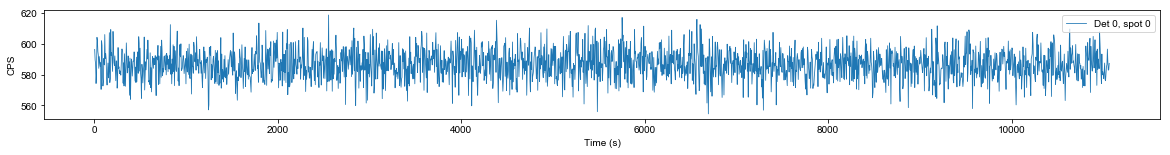

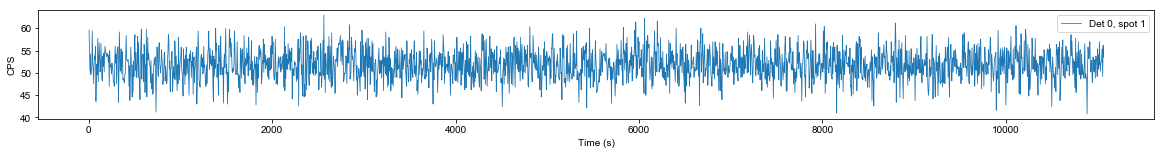

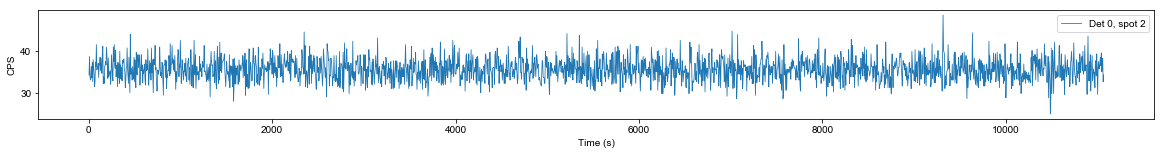

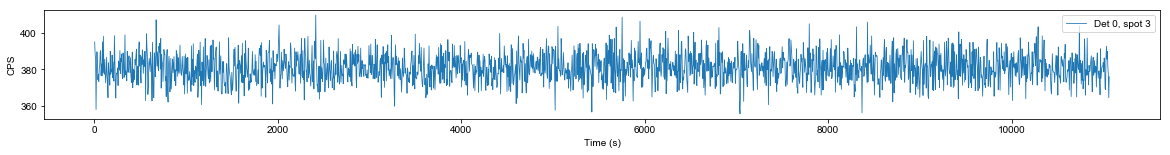

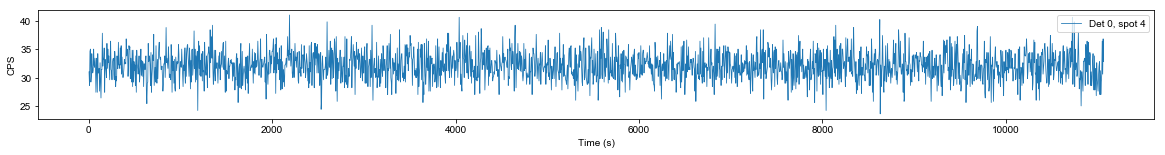

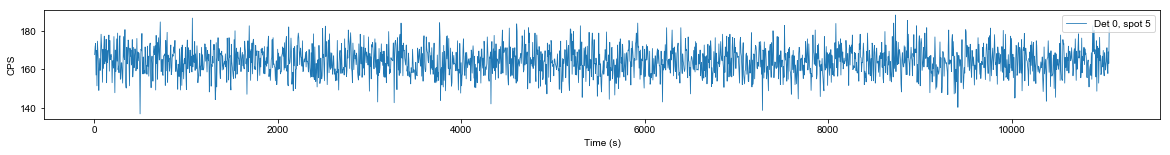

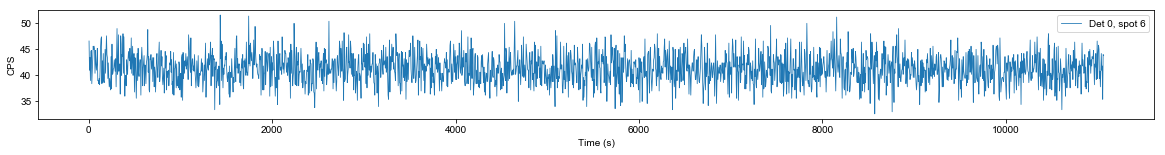

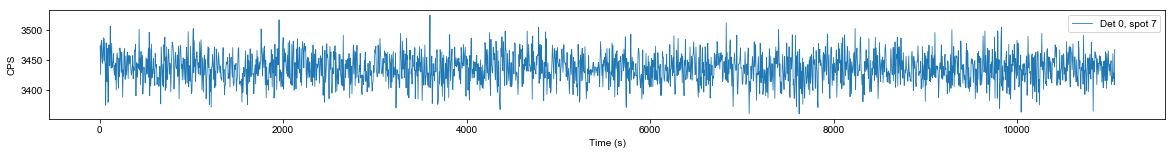

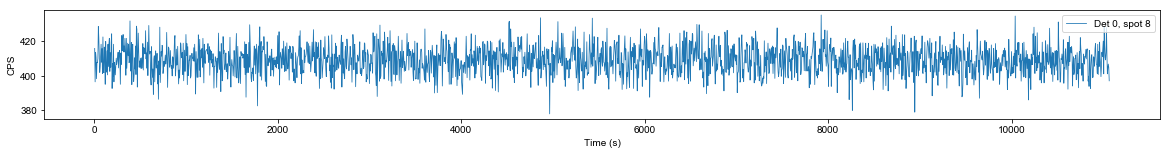

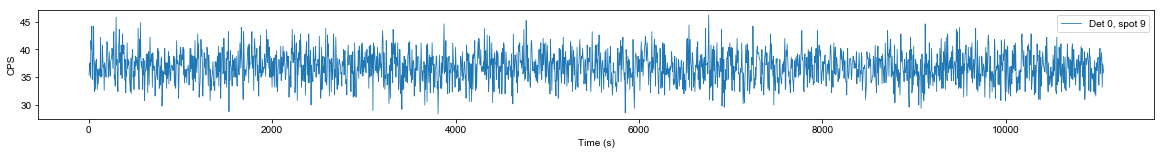

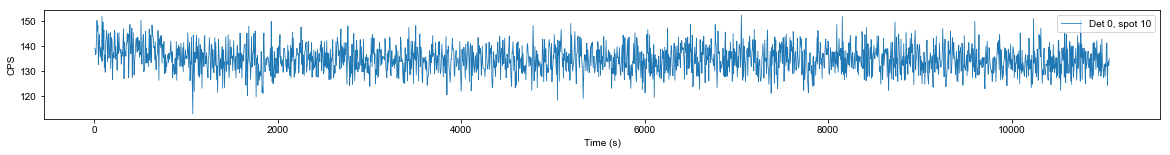

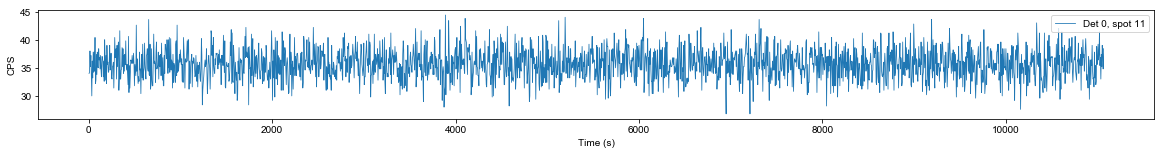

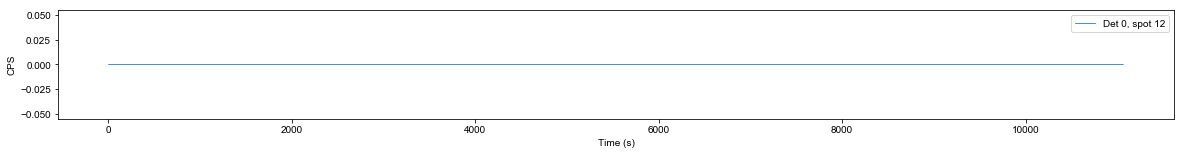

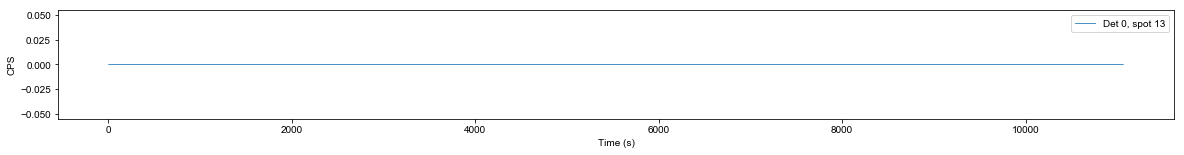

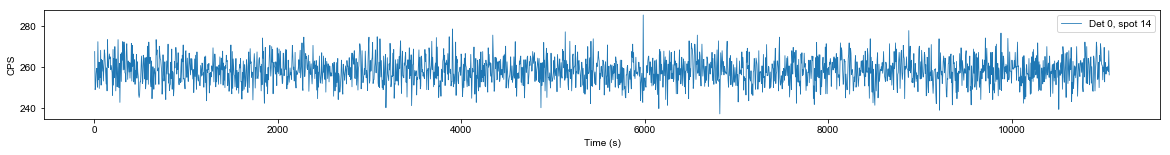

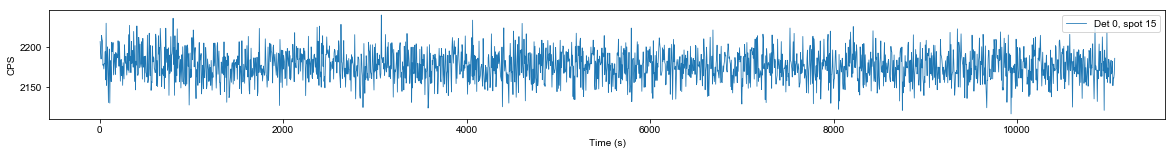

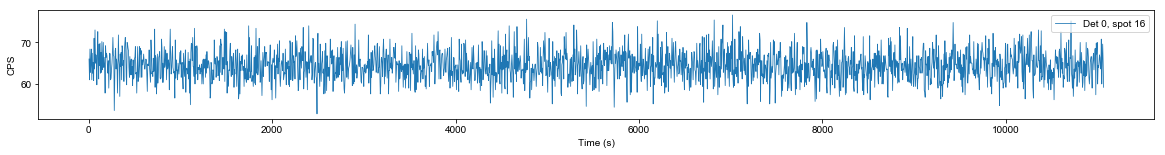

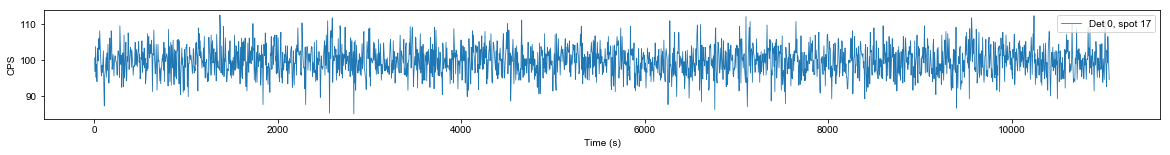

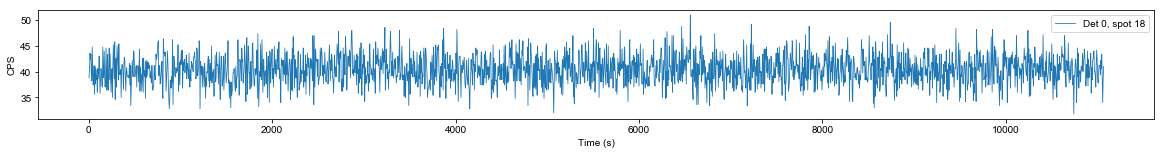

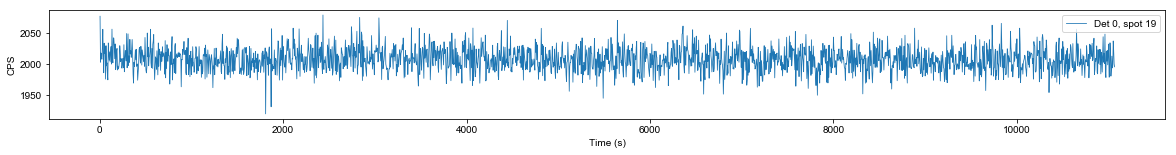

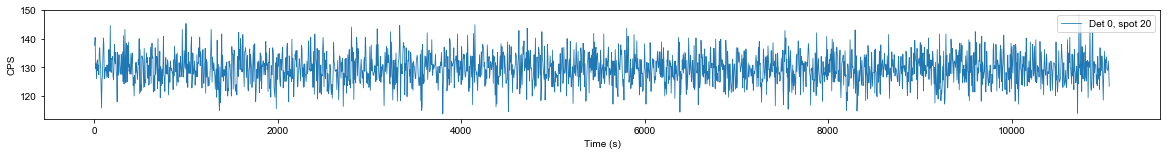

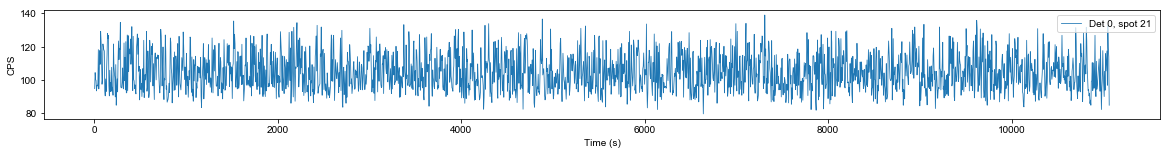

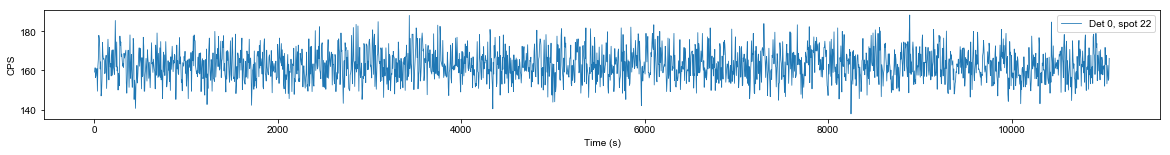

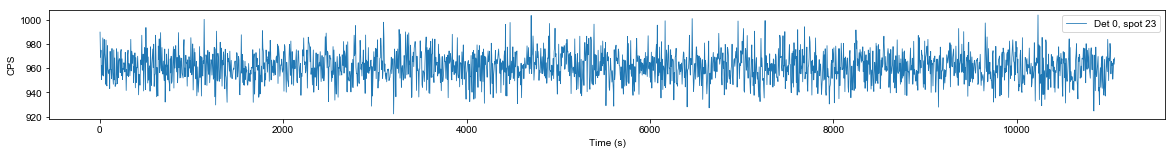

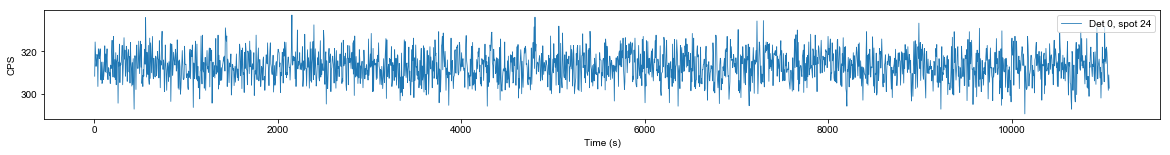

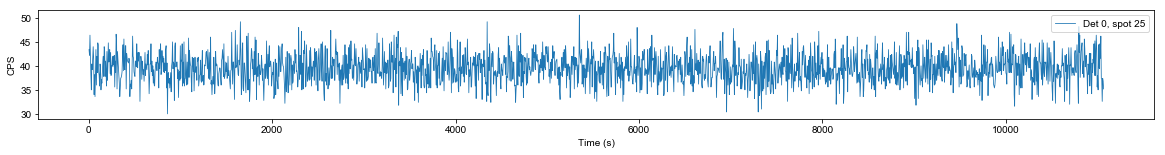

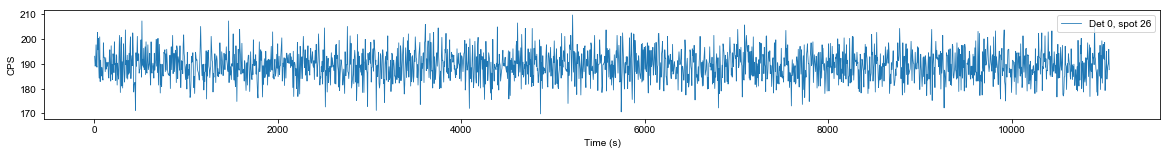

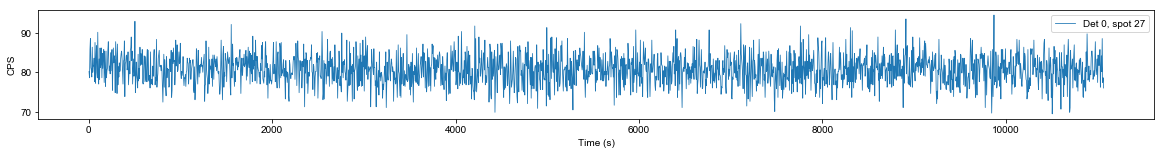

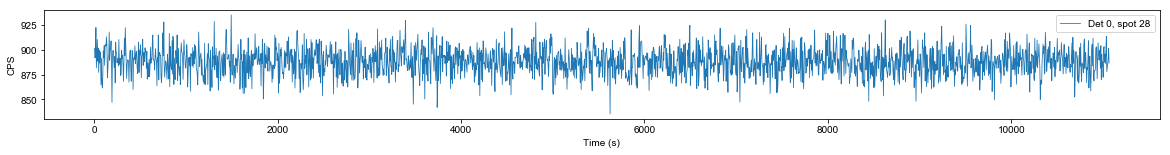

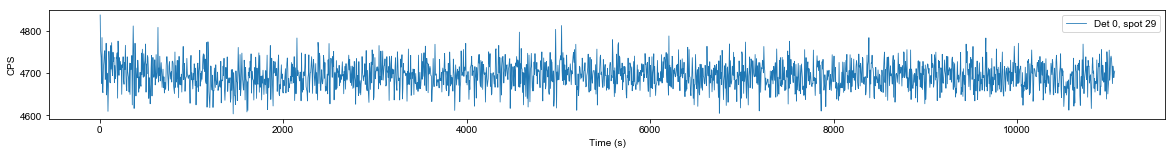

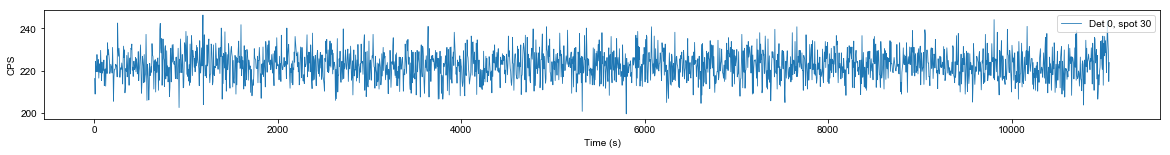

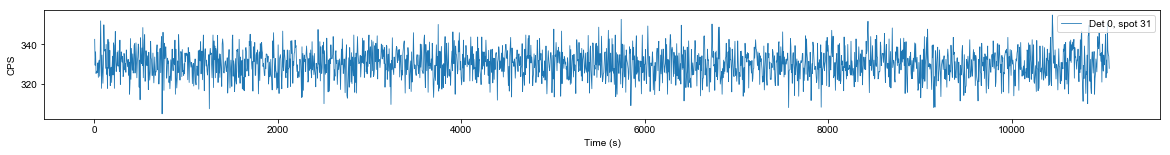

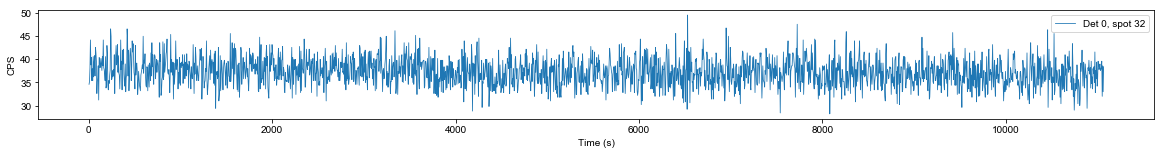

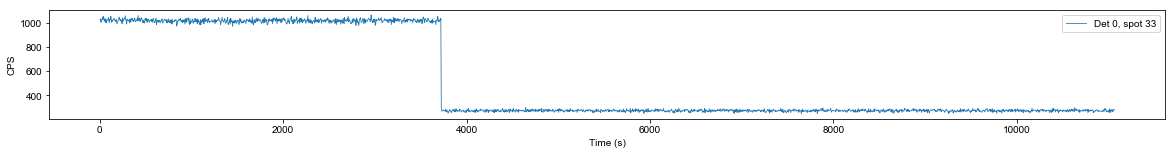

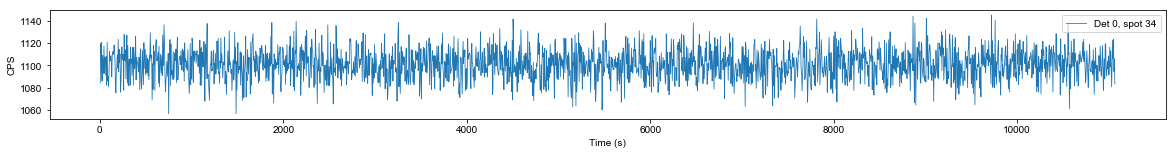

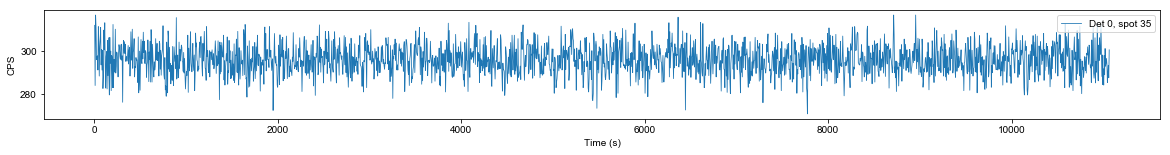

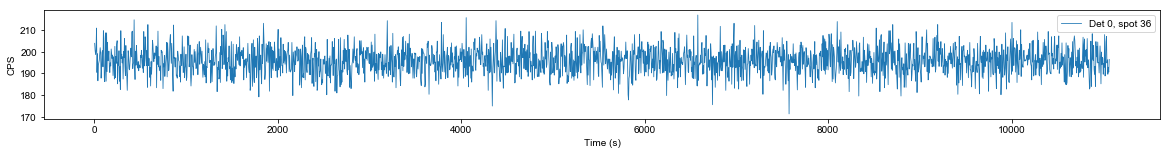

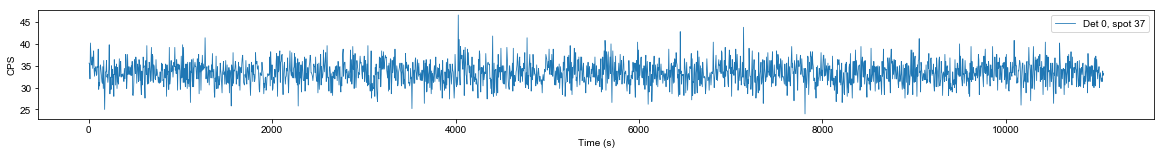

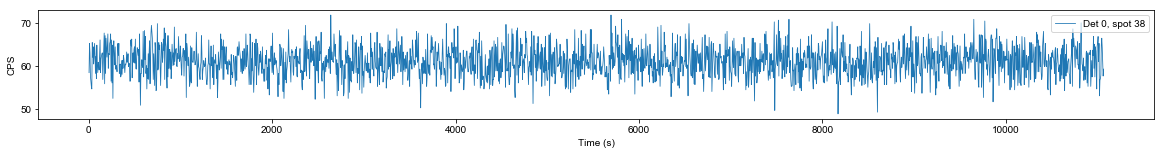

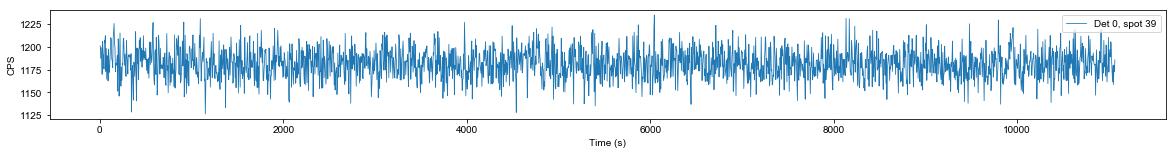

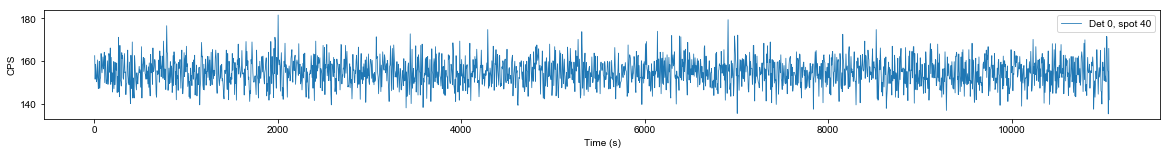

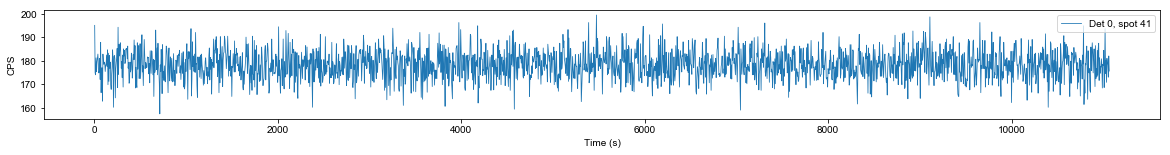

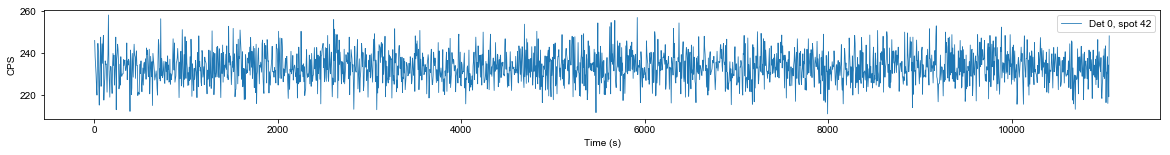

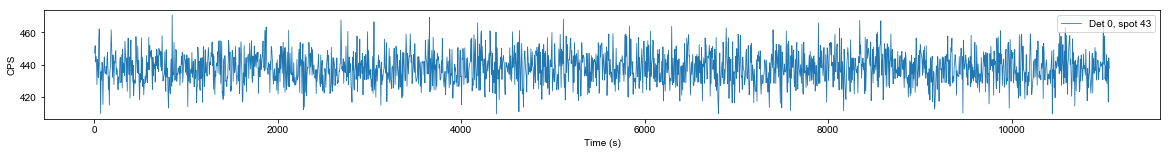

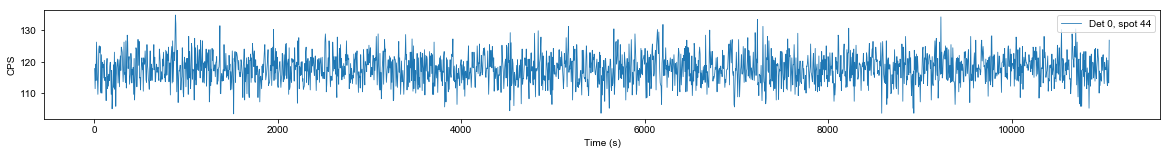

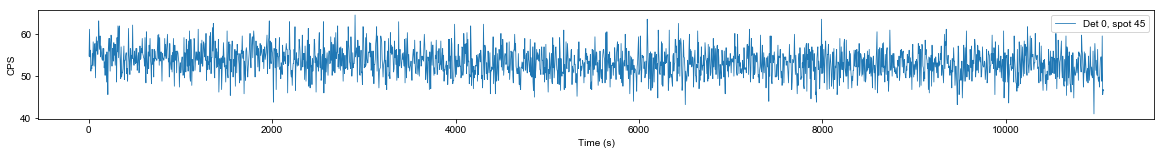

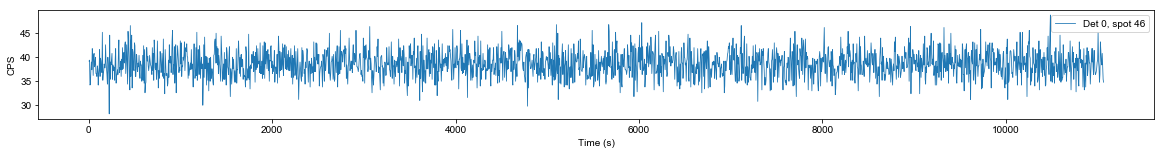

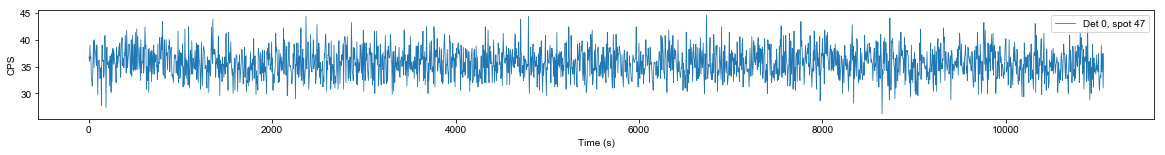

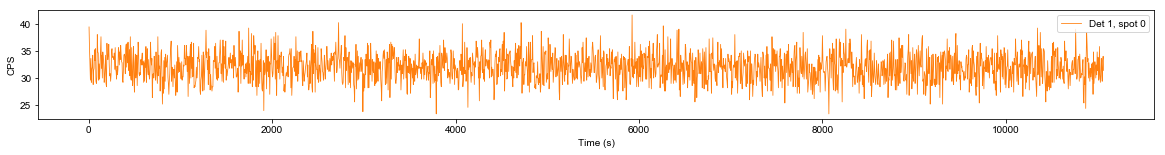

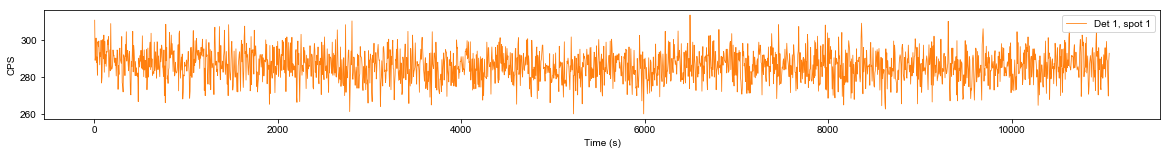

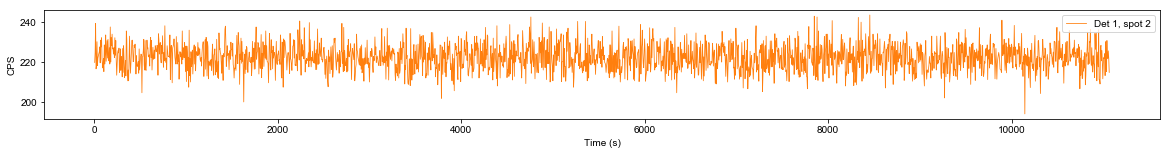

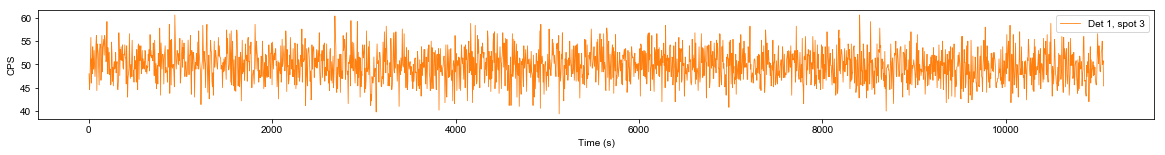

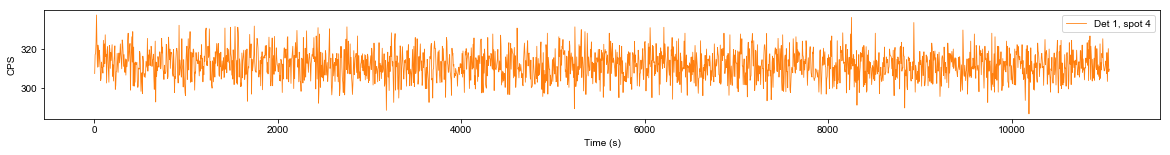

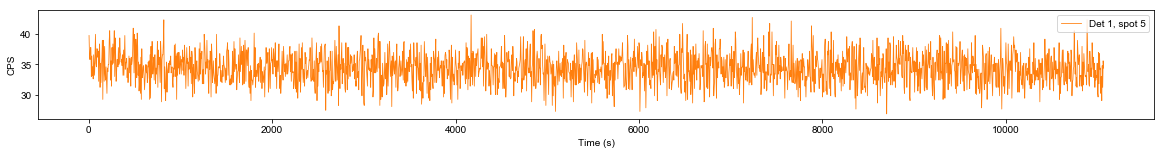

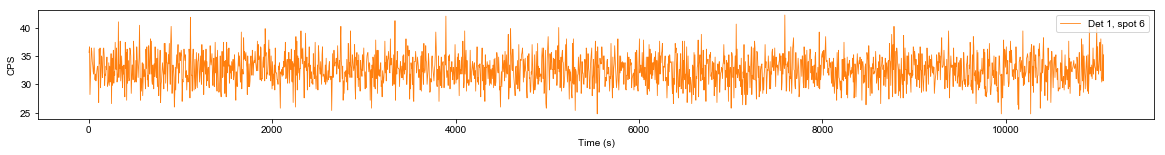

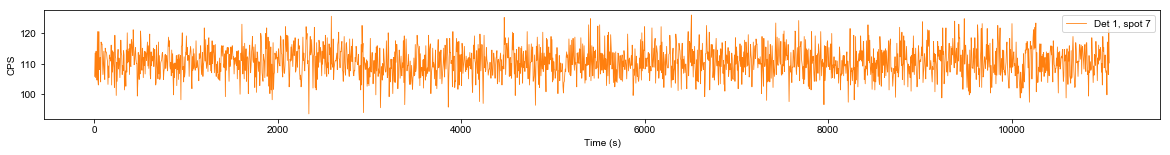

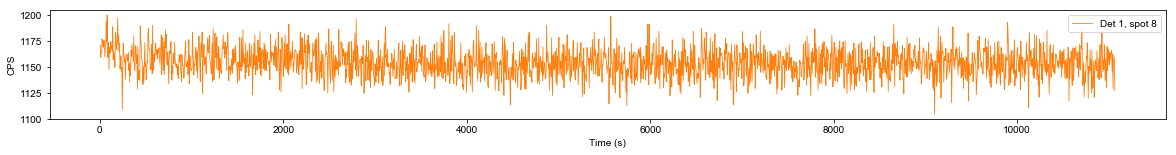

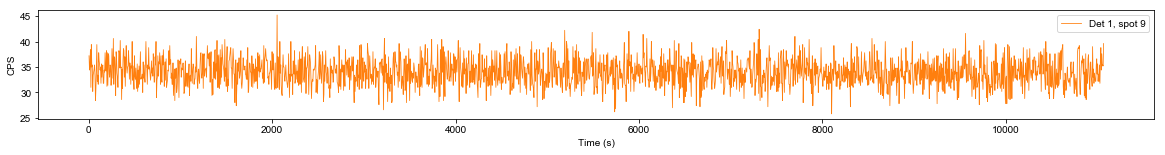

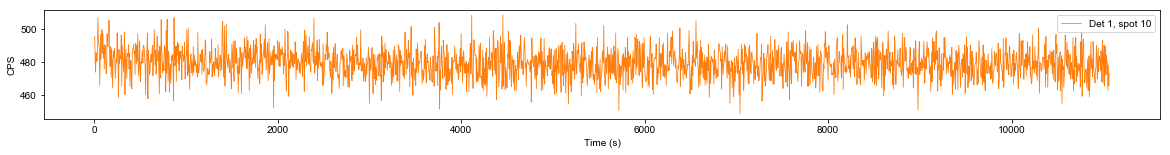

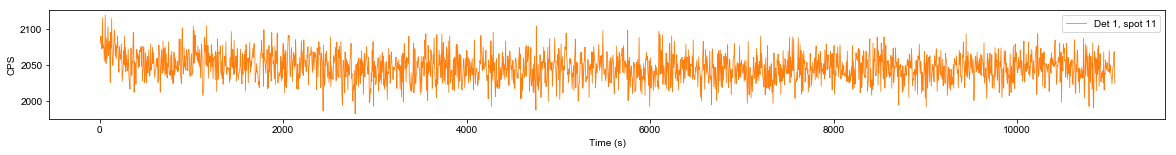

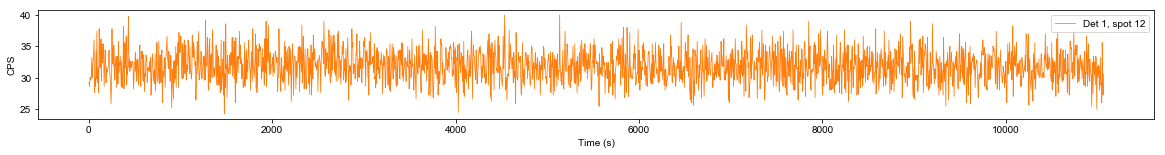

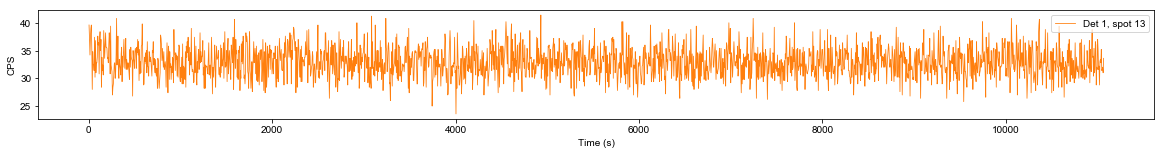

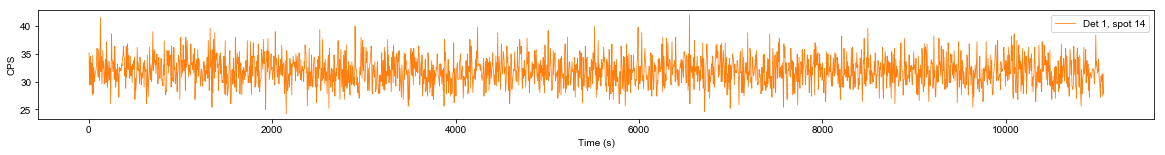

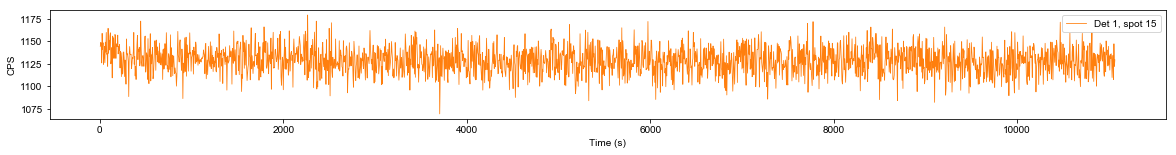

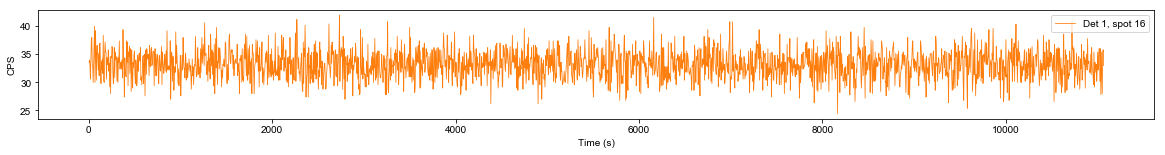

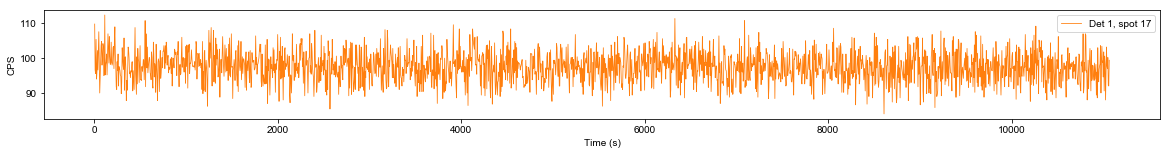

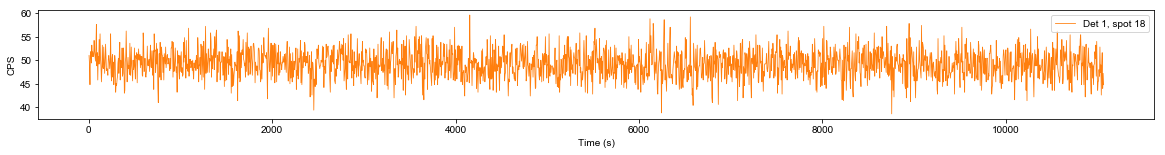

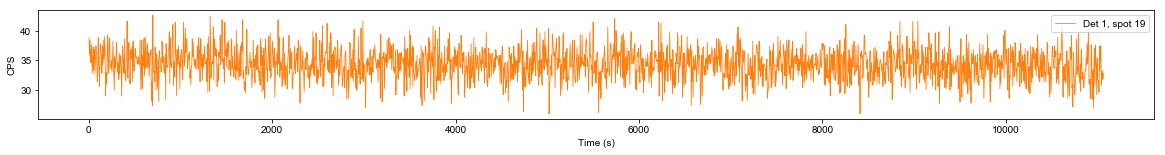

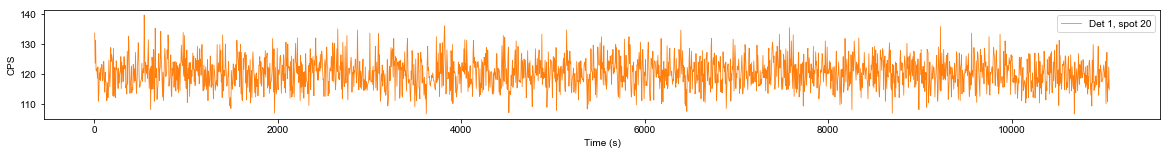

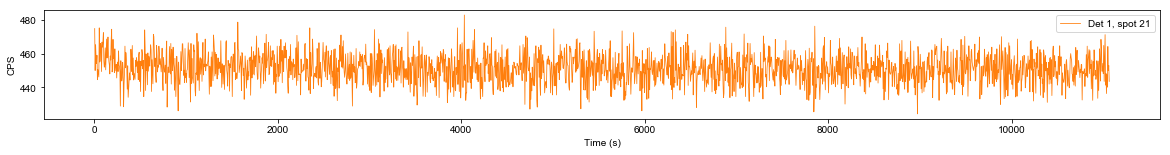

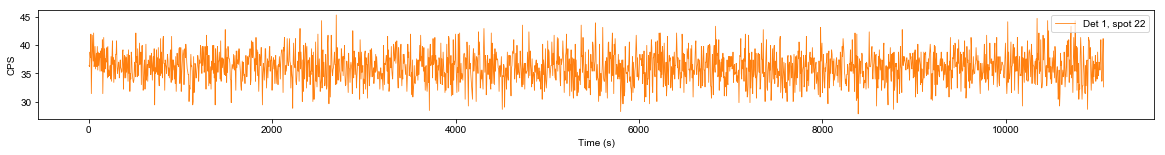

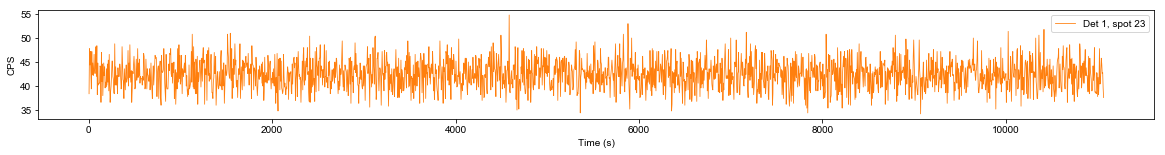

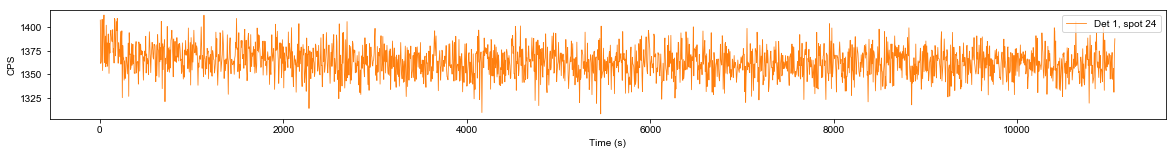

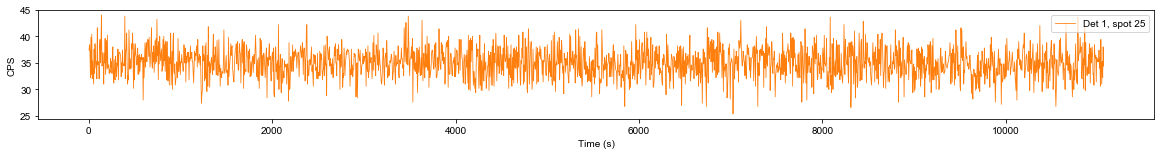

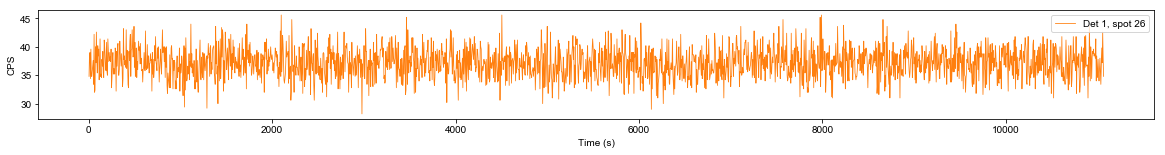

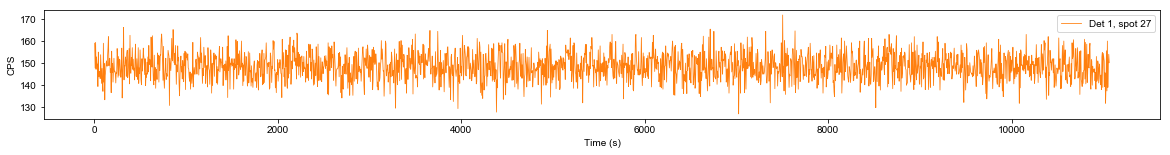

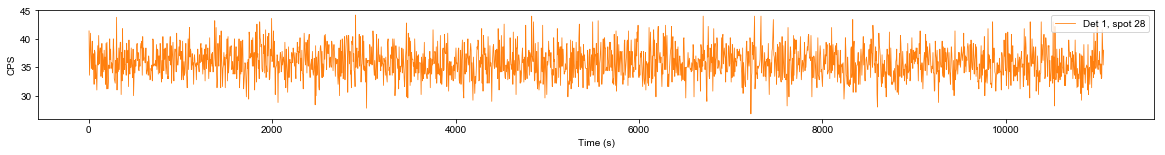

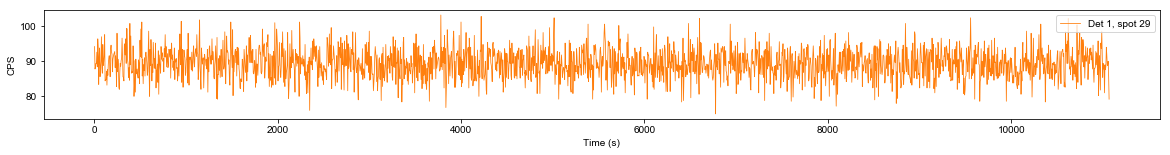

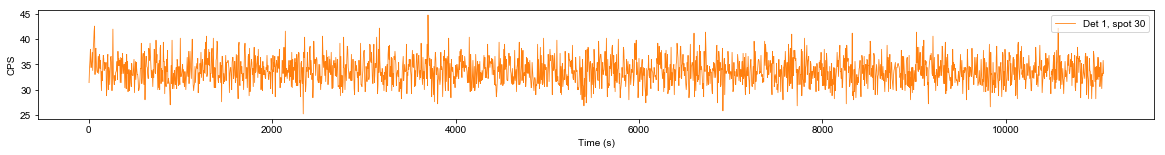

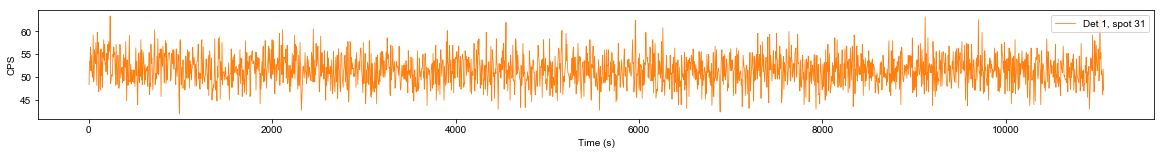

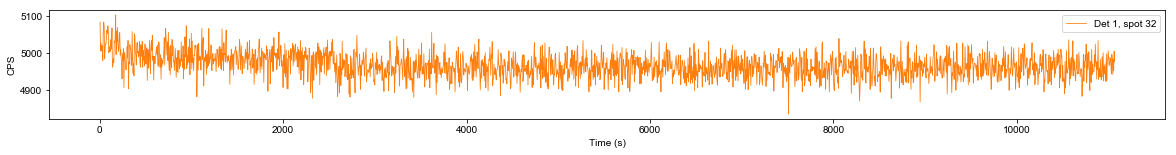

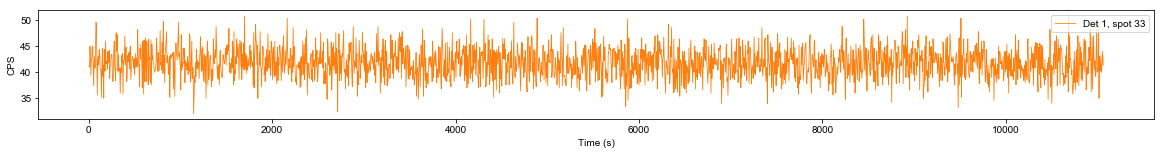

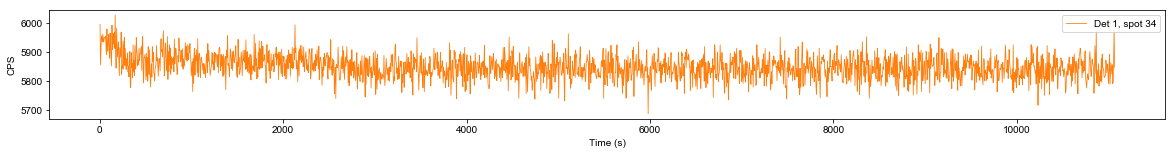

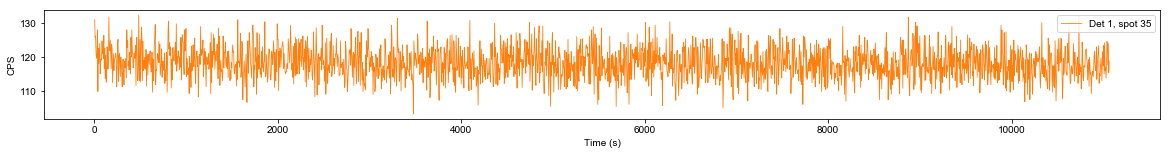

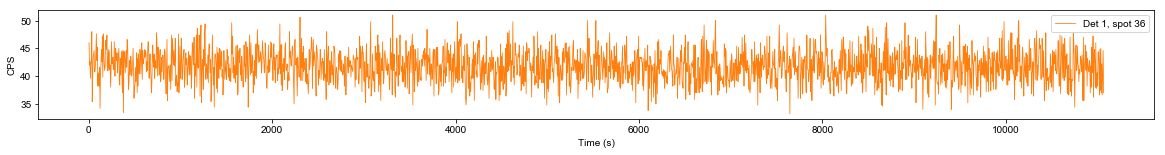

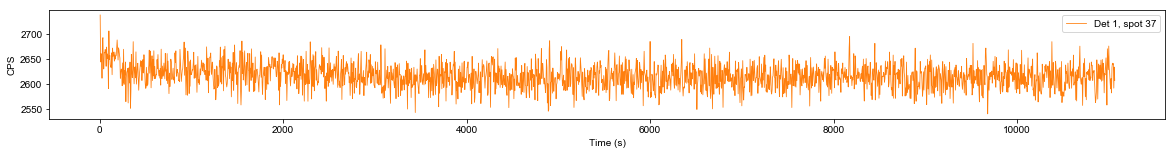

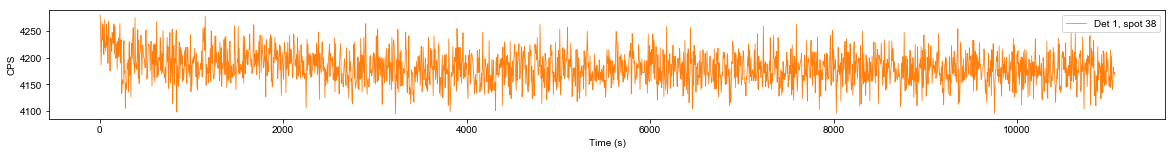

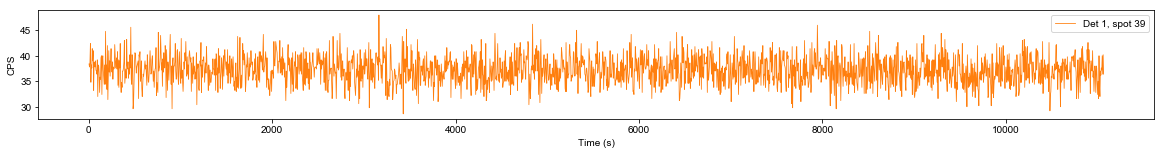

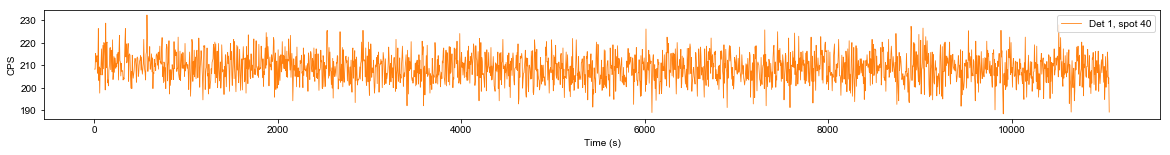

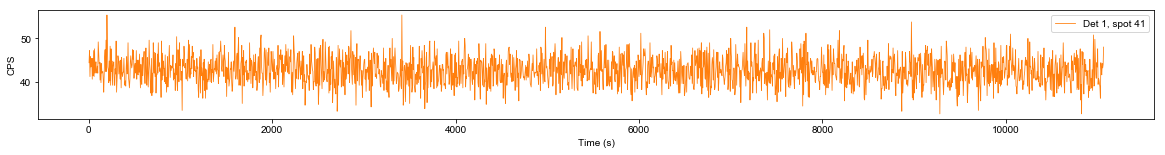

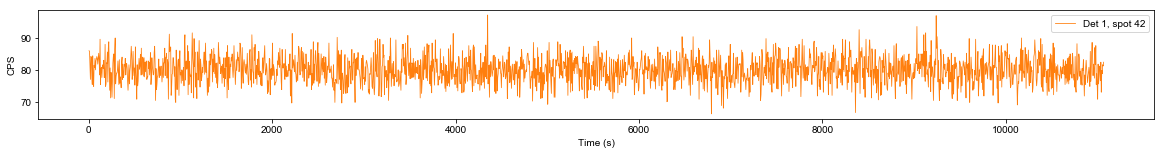

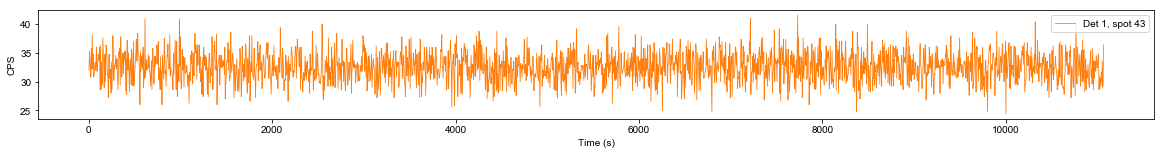

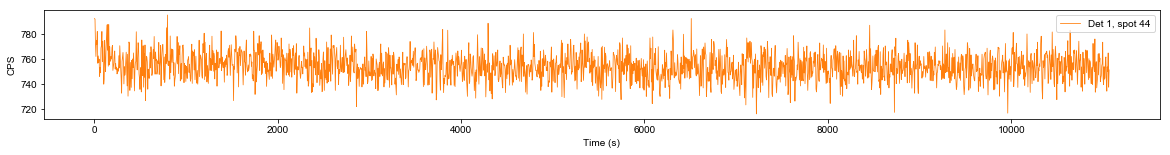

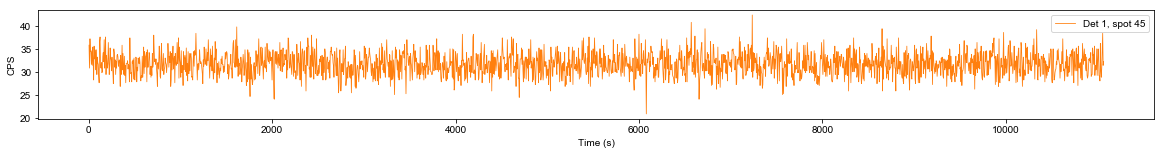

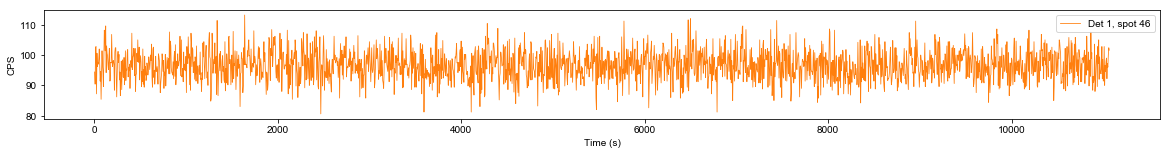

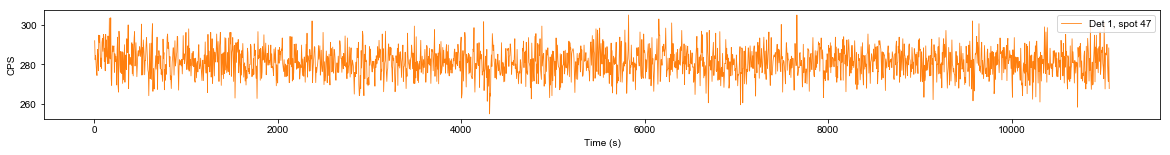

In [6]:
binwidth = 5  # seconds, timetrace bin
with plt.rc_context(rc={'font.size': 10}):
    for det in (0, 1):
        color = 'C0' if det == 0 else 'C1'
        spots = np.arange(48)
        for s in spots:
            ph = d.ph_times_m[s][d.detectors[s] == det] * d.clk_p
            counts, bins = np.histogram(ph, bins=np.arange(0, d.time_max, binwidth))

            fig, ax = plt.subplots(figsize=(20, 2))
            ax.plot(bins[1:], counts/binwidth, label='Det %d, spot %d' % (det, s), color=color, lw=0.8)
            ax.set_xlabel('Time (s)')
            ax.set_ylabel('CPS')
            plt.legend(loc='upper right')
            display(fig)
            plt.close(fig)

# DCR estimation

In [7]:
df = pd.DataFrame(np.zeros((48, 5)), columns = ['donor', 'acceptor', 'A_ch', 'D_ch', 'spot'])
detectors = d.setup['detectors']
for spot in range(48):
    for det in (0, 1):
        dcr = detectors['counts'][spot*2 + det] / d.acquisition_duration
        det_name = 'donor' if det == 0 else 'acceptor'
        df.loc[spot, det_name] = dcr
        
        det_col = 'D_ch' if det == 0 else 'A_ch'
        df.loc[spot, det_col] = detectors['id_hardware'][spot*2 + det]
        
        df.loc[spot, 'spot'] = spot
df.spot = df.spot.astype('int')
df.A_ch = df.A_ch.astype('int')
df.D_ch = df.D_ch.astype('int')
df['total'] = df.donor + df.acceptor

In [8]:
df

donor    acceptor  A_ch  D_ch  spot       total
0   586.625586   31.998428     0    84     0  618.624014
1    51.872385  285.993928     1    85     1  337.866314
2    35.523279  222.181302     2    86     2  257.704582
3   380.993702   49.868988     3    87     3  430.862691
4    32.095196  311.750499     4    88     4  343.845695
..         ...         ...   ...   ...   ...         ...
43  438.003921   32.589788    43    55    43  470.593710
44  117.769275  753.968033    44    56    44  871.737308
45   53.335833   31.709118    45    57    45   85.044951
46   38.615611   96.668413    46    58    46  135.284025
47   35.700462  281.295210    47    59    47  316.995672

[48 rows x 6 columns]

Text(0.5,0,'Spot No.')

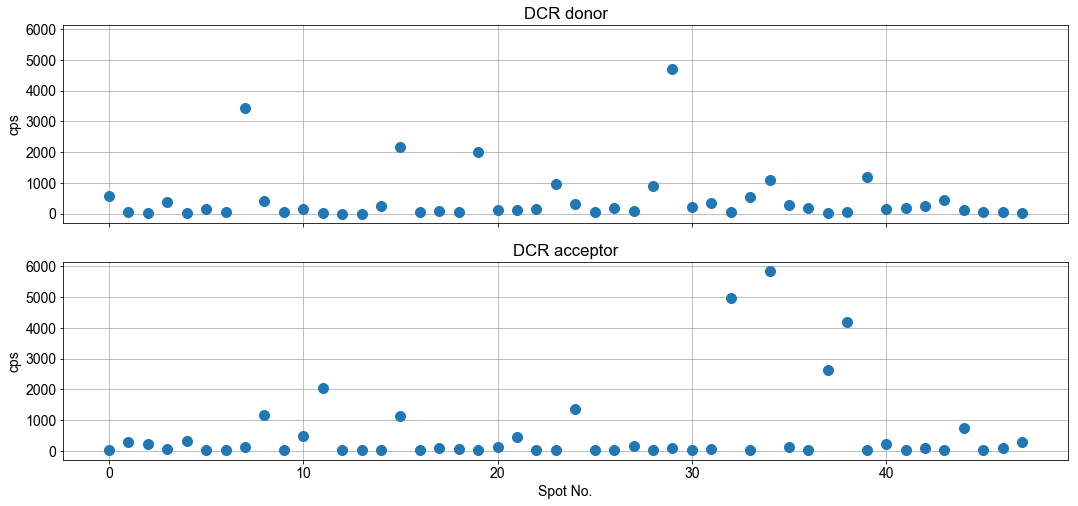

In [9]:
fig, Ax = plt.subplots(2, 1, figsize=(18, 8), sharey=True, sharex=True)

for ax, det in zip(Ax, ('donor', 'acceptor')):
    ax.plot(df[det], 'o', ms=10, label='DCR')
    ax.grid(True)
    ax.set_title('DCR %s' % det)
    ax.set_ylabel('cps')
ax.set_xlabel('Spot No.')

In [10]:
ich = 33
time_min = 4000
mask = d.ph_times_m[ich] > time_min / d.clk_p
ph = d.ph_times_m[ich][mask]
det = d.detectors[ich][mask]
duration = (ph[-1] - ph[0]) * d.clk_p
dcr = (det == 0).sum() / duration
dcr

273.84988304631497

In [11]:
df.loc[ich, 'donor'] = dcr
df['total'] = df.donor + df.acceptor

Text(0.5,0,'Spot No.')

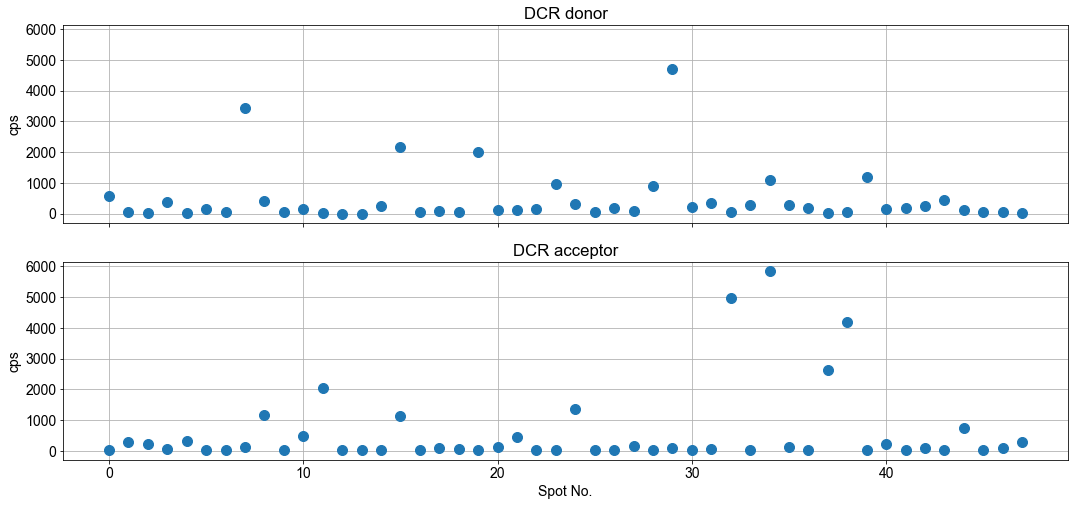

In [12]:
fig, Ax = plt.subplots(2, 1, figsize=(18, 8), sharey=True, sharex=True)

for ax, det in zip(Ax, ('donor', 'acceptor')):
    ax.plot(df[det], 'o', ms=10, label='DCR')
    ax.grid(True)
    ax.set_title('DCR %s' % det)
    ax.set_ylabel('cps')
ax.set_xlabel('Spot No.')

In [13]:
df.to_csv(f'results/{mlabel}_rates.csv')